Edric Franco <br>
12/2018

Let us Forecast Apple stock prices (Ticker = 'AAPL') <br>
Using the TwitterBot_Model.py we created:

- Let us first Scrape Twitter data
- Apply sentiment analysis
- Merge prices of stock

# Data Scraping

In [1]:
%%capture
# Import our Twitter/Sentiment/Stock Price Scraper
from TwitterBot_Model import Twitter_Sentiment_Bot
import datetime as dt

ticker='AAPL'
begin_date=dt.date(2018,1 ,1)
end_date= dt.date(2018, 12, 31)

scrap = Twitter_Sentiment_Bot(ticker=ticker,
                              begin_date=begin_date,
                              end_date=end_date)

limit = 5
lang = 'english'
scrap.run_all(limit=limit,
                   lang=lang)
df = scrap.df

- Our plan is to first use the Sentiment Scores we got from TwitterBot_Model.py to model Stock Prices for Apple
- We then use Time Series Analysis to model the residuals of our predictions and add the forecasted residuals to our predictions
- This is a variation of the standard ARIMAX model where we use another machine learning model instead of standard linear regression

# Exploration

In [3]:
# Import Packages

# Preprocessing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Exploration
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Models
from sklearn.svm import SVR
from pyramid.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

# Hyperparameters
from hyperparameters import SVM_PARAMS
from hyperparameters import ARIMA_PARAMS

#  Model Validation
from sklearn.metrics import mean_absolute_error

# We model log prices for numerical stability
# Train on first 230 days of the trading year, Test on last 20 trading days
df = df.set_index('Date')
df = df.dropna(axis=0)
df['log_price'] = np.log(df['Adj Close']) # log prices
df.index = pd.to_datetime(df.index)
df_train = df[:230] # first  200 stock prices
df_test = df[230:] # test on last month stock prices

- Let us first explore the relationship between the Sentiment Scores and the Log Stock Prices

Text(0.5, 1.0, 'Sentiment Scores vs. Log Prices')

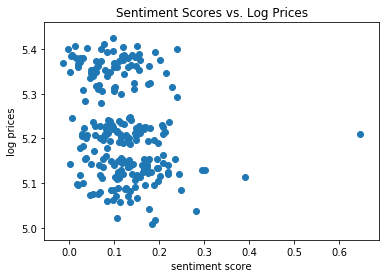

In [4]:
plt.scatter(x=df_train['sentiment'], y=df_train['log_price'])
plt.xlabel('sentiment score')
plt.ylabel('log prices')
plt.title('Sentiment Scores vs. Log Prices')

- It appears that Sentiment Scores and Log Prices do not have a linear relationship
- An SVM regressor with a RBF kernel appears to be a good model

# Modeling Log Stock Prices with Twitter Sentiment Scores

In [5]:
model_SVR = SVR(**SVM_PARAMS)
model_SVR.fit(df_train[['sentiment']], df_train[['log_price']])
df_train['pred'] = model_SVR.predict(df_train[['sentiment']])
df_test['pred'] = model_SVR.predict(df_test[['sentiment']])
df_train['residuals'] = df_train['log_price'] - df_train['pred']
df_test['residuals'] = df_test['log_price'] - df_test['pred']
# We now fit a time series  model to the residuals

# Modeling the residuals of our Forecasts (Time Series)

Text(0, 0.5, 'Residuals')

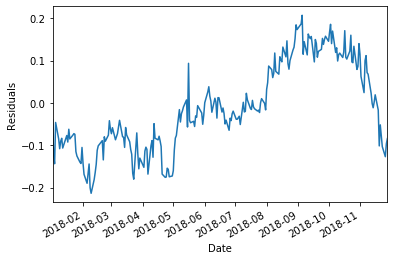

In [6]:
# Plot Time Series
df_train['residuals'].plot()
plt.ylabel('Residuals')

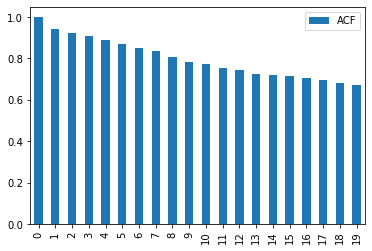

In [7]:
acf_1 = acf(df_train['residuals'])[0:20]
df_1 = pd.DataFrame([acf_1]).T
df_1.columns=['ACF']
df_1.plot(kind='bar')

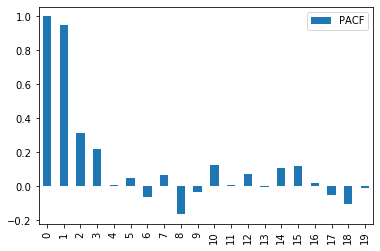

In [8]:
pacf_1 = pacf(df_train['residuals'])[0:20]
df_1 = pd.DataFrame([pacf_1]).T
df_1.columns=['PACF']
df_1.plot(kind='bar')

We can see from the Time Series Plot:
- There appears to be an upward trend in the residuals

We can see that the ACF tends to tail off very slowly:
- This could be a sign that our Series is integrated
- Let us take the first order difference

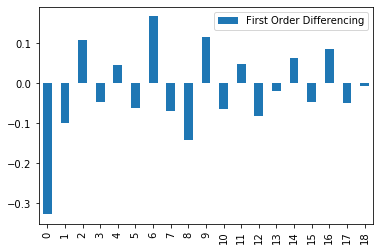

In [9]:
res_diff = df_train['residuals'] - df_train['residuals'].shift()
res_diff = res_diff.dropna()
acf_1_diff = acf(res_diff)[1:20]
test_df = pd.DataFrame([acf_1_diff]).T
test_df.columns = ['First Order Differencing']
test_df.plot(kind='bar')

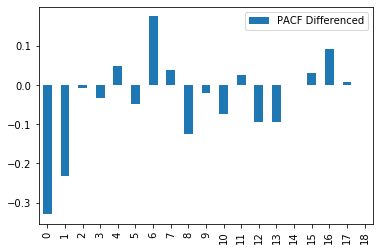

In [10]:
pacf_1_diff = pacf(res_diff)[1:20]
df = pd.DataFrame([pacf_1_diff]).T
df.columns=['PACF Differenced']
df.plot(kind='bar')

- There appears to be seasonality in the residuals of our predictions
- Let us use auto arima to find the parameters that minimize AIC
- We also set our ARIMA to be integrated since the differenced series appears to be more stationary

In [11]:
ts_model = auto_arima(df_train['residuals'], **ARIMA_PARAMS)
print(ts_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-838.631, BIC=-821.731, Fit time=2.221 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-709.447, BIC=-702.687, Fit time=0.089 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-778.400, BIC=-764.880, Fit time=1.838 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-840.795, BIC=-827.276, Fit time=1.854 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-838.840, BIC=-821.940, Fit time=2.240 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-732.156, BIC=-722.016, Fit time=0.224 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-838.874, BIC=-821.974, Fit time=4.107 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-837.453, BIC=-817.174, Fit time=6.131 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-812.649, BIC=-802.509, Fit time=1.798 seconds
Fit ARIMA: order=(0, 1, 2) s

- We integrated this whole process of first fitting a SVM regressor to use Sentiment Scores to model Stock Prices followed by adding the forecasted residuals using Time Series Analysis to model the time series nature of Prices in arima_svm.py 

# Model Validation
- In this block we apply time series cross validation. <br>

That is, We validate our predictions with one step ahead predictions by retraining every iteration

In [21]:
%%capture

# Import our created model in arima_svm.py
from arima_svm import ARIMA_SVM #  see arima_svm.py to view the created model

model = ARIMA_SVM()
forecasts=[]
for i in range(len(df_test)):
    x_train = pd.concat([df_train[['sentiment']], df_test.iloc[i-1:i, 0:1]])
    y_train = pd.concat([df_train[['log_price']], df_test.iloc[i-1:i, 2:3]])
    
    fore = model.fit_predict(x_train = x_train,
                      y_train = y_train,
                      x_test = df_test.iloc[i:i+1, 0:1])
    
    forecasts.append(fore)
    
pred=pd.DataFrame(forecasts, columns=['forecasts'])
pred.index = df_test.index

In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['log_price'],
                         mode='lines+markers',
                         name='True Log Apple Stock Price'))

fig.add_trace(go.Scatter(x=pred.index, y=pred['forecasts'],
                    mode='lines+markers',
                    name='Forecasted Log APPLE Stock Prices'))

fig.update_layout(title='Log Prices and Forecasted Prices for Apple Stock',
                   xaxis_title='Date',
                   yaxis_title='Log Price')

fig.show('svg')

In [49]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['Adj Close'],
                         mode='lines+markers',
                         name='True Apple Closing Stock Prices'))

fig.add_trace(go.Scatter(x=pred.index, y=np.exp(pred['forecasts']),
                    mode='lines+markers',
                    name='Forecasted Apple Stock Prices'))

fig.update_layout(title='Adjusted Closing Price and Forecasted Adjusted Closing Price for Apple Stock',
                   xaxis_title='Date',
                   yaxis_title='Adjusted CLosing Price')

fig.show('svg')

In [54]:
mae_log = mean_absolute_error(pred['forecasts'], df_test['log_price'])
mae_price = mean_absolute_error(np.exp(pred['forecasts']), df_test['Adj Close'])
print('MAE for log Apple Stock Prices are: {}'.format(mae_log))
print('MAE for Apple Stock Prices are: {}'.format(mae_price))

MAE for log Apple Stock Prices are: 0.035903360999561595
MAE for Apple Stock Prices are: 5.761410095298278


The Mean Absolute Error of our model is 5.76 <br>
This means:
- On average, our model gets a forecast of within $5.76 above or below the True Apple stock prices
- I believe this is a relatively good forecast given that we did not have a large dataset
- We could improve this model by adding more variables or modeling the 2 time series jointly

- If our model predicts a forecast of above $5.76 the current stock price, then I would advise to buy the Stock